In [ ]:
!pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.6/164.6 kB 3.1 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

# Load data and calculate features
df = pd.read_csv('/content/SPY.csv')
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

In [16]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [17]:
df['RSI'] = calculate_rsi(df)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility'] = df['Close'].rolling(window=10).std()
df['Return'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

In [18]:
train_data = df.iloc[:2706]
test_data = df.iloc[2706:]
hidden_states = 4
model = hmm.GaussianHMM(n_components=hidden_states, covariance_type="full", n_iter=75)
obs_train = train_data[['Volatility', 'Return', 'EMA_10', 'RSI']].values
model.fit(obs_train)
predictions = model.predict(obs_train)

In [19]:
train_data['Predicted Regime'] = predictions
volatility_threshold = train_data['Volatility'].mean()
train_data['Volatility_Label'] = train_data['Volatility'].apply(lambda x: 1 if x > volatility_threshold else 0)

<ipython-input-19-2104272a8c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Predicted Regime'] = predictions
<ipython-input-19-2104272a8c3f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Volatility_Label'] = train_data['Volatility'].apply(lambda x: 1 if x > volatility_threshold else 0)


In [20]:
regime_volatility = {regime: np.mean(train_data[train_data['Predicted Regime'] == regime]['Volatility']) for regime in range(hidden_states)}
predicted_labels = [1 if regime_volatility[regime] > volatility_threshold else 0 for regime in predictions]

In [21]:
pseudo_accuracy_percentage = np.mean(train_data['Volatility_Label'].values == predicted_labels) * 100
print(f"Pseudo-accuracy percentage based on volatility alignment: {pseudo_accuracy_percentage:.2f}%")

Pseudo-accuracy percentage based on volatility alignment: 81.78%


In [22]:
obs_test = test_data[['Volatility', 'Return', 'EMA_10', 'RSI']].values
log_likelihood_test = model.score(obs_test)
print(f"Log-Likelihood on Test Set: {log_likelihood_test:.2f}")

Log-Likelihood on Test Set: -94868.84


Transition Probability Matrix: [[9.97953309e-001 2.04669098e-003 8.27817405e-031 1.19216012e-228]
 [4.27216177e-014 9.80434913e-001 2.24972321e-113 1.95650868e-002]
 [1.94659235e-003 1.25357220e-135 9.98053408e-001 0.00000000e+000]
 [9.48665520e-241 1.98914529e-002 0.00000000e+000 9.80108547e-001]]


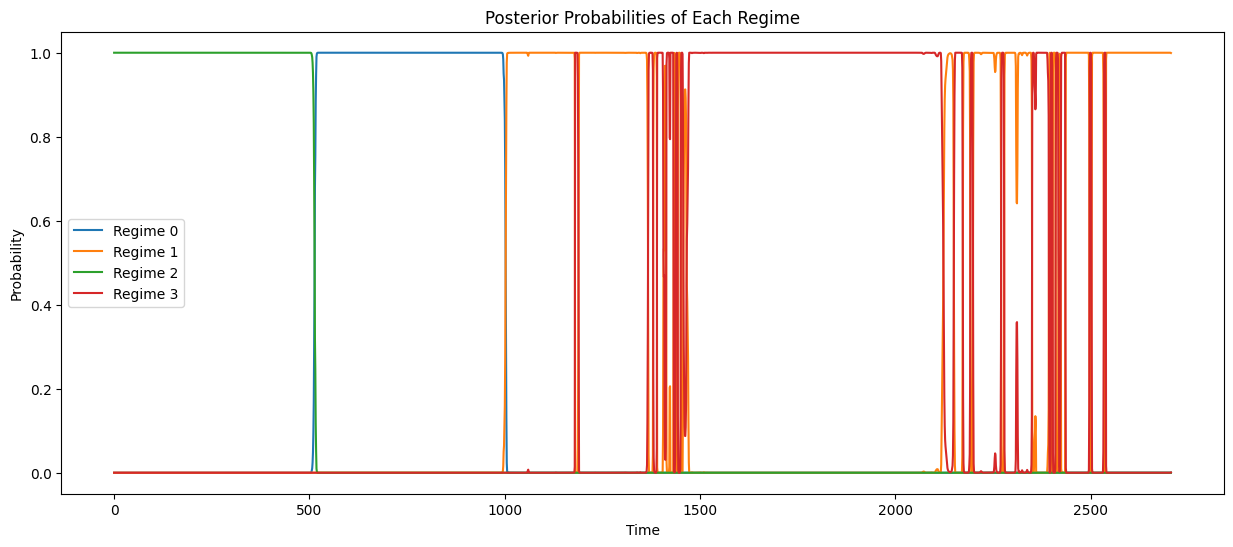

In [23]:
print("Transition Probability Matrix:", model.transmat_)
posterior_probs = model.predict_proba(obs_train)
plt.figure(figsize=(15, 6))
for i in range(hidden_states):
    plt.plot(posterior_probs[:, i], label=f'Regime {i}')
plt.title('Posterior Probabilities of Each Regime')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [24]:
regime_labels = {
    0: "Low Volatility - Stable",
    1: "Moderate Volatility - Caution",
    2: "High Volatility - Risky",
    3: "Stable - Trend-following"
}

# Predict the next regime after the latest observation in the training data
latest_volatility = train_data.iloc[-1]['Volatility']
latest_return = train_data.iloc[-1]['Return']
latest_ema = train_data.iloc[-1]['EMA_10']
latest_rsi = train_data.iloc[-1]['RSI']
latest_observation = np.array([[latest_volatility, latest_return, latest_ema, latest_rsi]])

In [27]:
next_regime = model.predict(latest_observation)[0]
labeled_regime = regime_labels.get(next_regime, "Unknown Regime")
print(f"The predicted next regime is: Regime {next_regime} - {labeled_regime}")

The predicted next regime is: Regime 0 - Low Volatility - Stable


In [28]:
from hmmlearn import hmm

# Function to calculate AIC and BIC for different HMM models
def calculate_aic_bic(data, max_states=4):
    results = []
    for n_states in range(2, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=75)
        model.fit(data)

        log_likelihood = model.score(data)
        num_params = n_states**2 + 2 * n_states - 1  # Parameters: transitions + means + variances

        # AIC and BIC calculations
        aic = 2 * num_params - 2 * log_likelihood
        bic = np.log(len(data)) * num_params - 2 * log_likelihood

        results.append((n_states, aic, bic))
        print(f"States: {n_states}, AIC: {aic:.2f}, BIC: {bic:.2f}")

    return results

# Prepare data for HMM model (using Volatility and Return)
obs = train_data[['Volatility', 'Return']].values

# Run AIC and BIC calculations
results = calculate_aic_bic(obs, max_states=4)

# Selecting optimal number of states based on minimum BIC value
optimal_states = min(results, key=lambda x: x[2])[0]
print(f"Optimal number of states based on BIC: {optimal_states}")


States: 2, AIC: 11973.15, BIC: 12014.47
States: 3, AIC: 9900.19, BIC: 9982.83
States: 4, AIC: 9001.63, BIC: 9137.40
Optimal number of states based on BIC: 4


<ipython-input-29-5ee16154738d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Predicted Regime'] = predictions  # Assuming 'predictions' contain the regimes assigned during training
<ipython-input-29-5ee16154738d>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(hidden_states), y=regime_counts, ax=ax, palette="viridis")


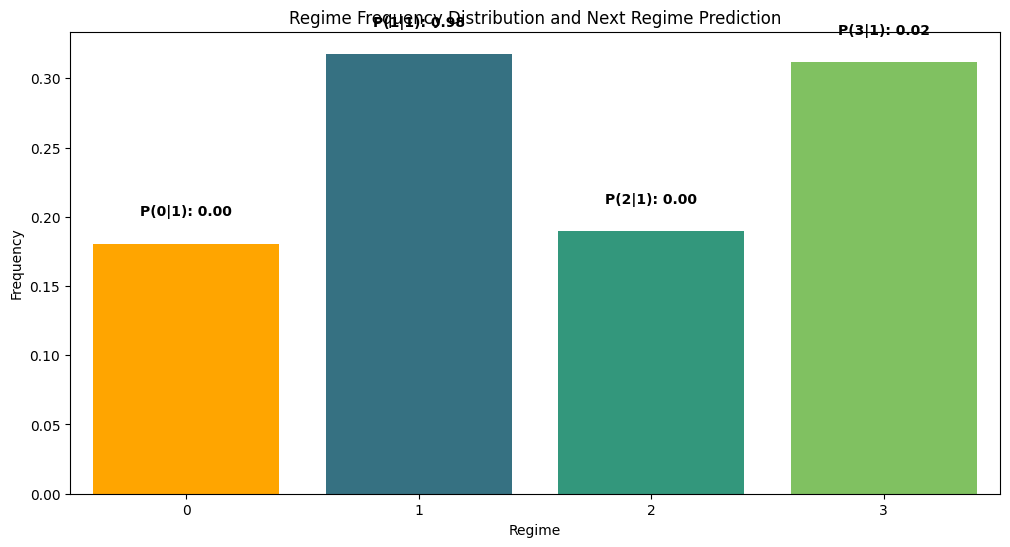

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data setup for plotting
train_data['Predicted Regime'] = predictions  # Assuming 'predictions' contain the regimes assigned during training
current_regime = train_data['Predicted Regime'].iloc[-1]  # The latest predicted regime for the final day in training

# Regime frequency distribution
regime_counts = train_data['Predicted Regime'].value_counts(normalize=True).sort_index()

# Transition Probability Matrix (assume we have `model.transmat_` from the HMM model)
transition_matrix = model.transmat_

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Distribution plot for regime frequency
sns.barplot(x=range(hidden_states), y=regime_counts, ax=ax, palette="viridis")
ax.set_title("Regime Frequency Distribution and Next Regime Prediction")
ax.set_xlabel("Regime")
ax.set_ylabel("Frequency")

# Highlight the predicted next regime
predicted_next_regime = next_regime  # `next_regime` should contain the predicted regime for the next day
highlight_color = "orange"
ax.patches[predicted_next_regime].set_facecolor(highlight_color)

# Annotate transition probabilities from current regime to each possible regime
for i, prob in enumerate(transition_matrix[current_regime]):
    ax.text(i, regime_counts[i] + 0.02, f"P({i}|{current_regime}): {prob:.2f}",
            ha='center', color='black', fontweight='bold')

# Show plot
plt.show()